In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =4

nref =2

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 1 , 3 /) 

data wgt
     &     /0.45 , 0.55 , 0.65 , 0.95/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66/

klin =5e-25

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

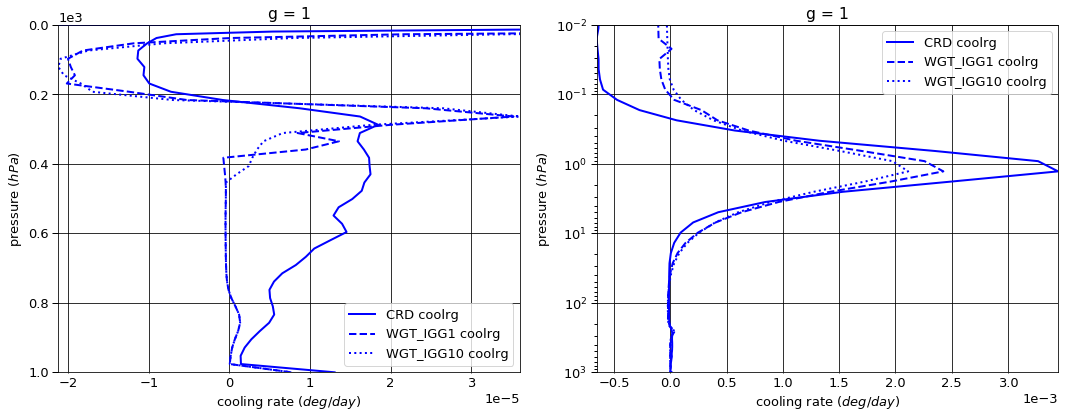

# Figure: cooling rate g-group 2

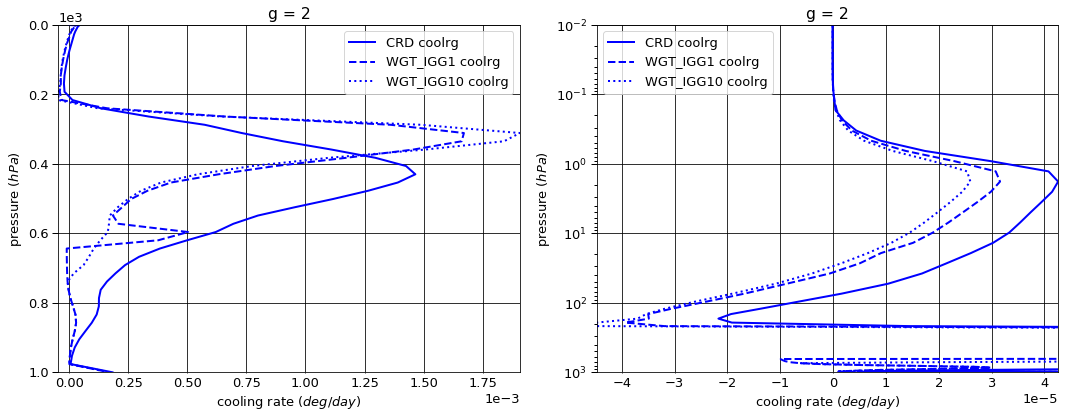

# Figure: cooling rate g-group 3

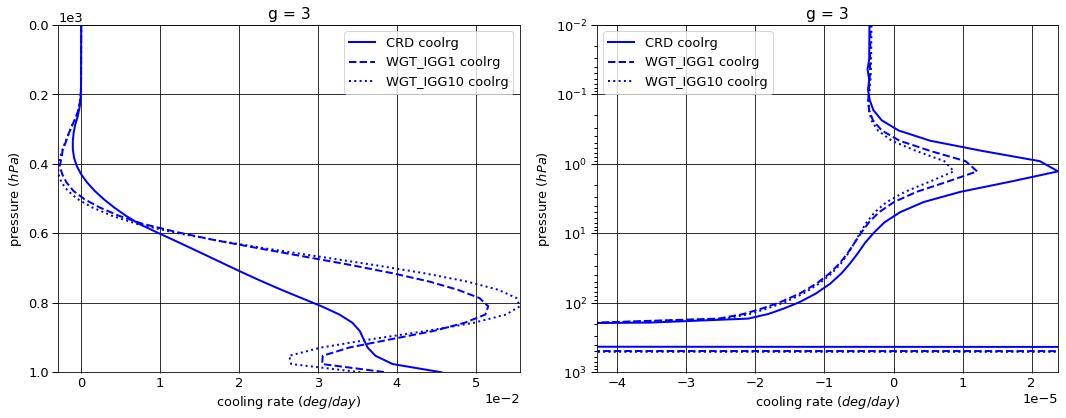

# Figure: cooling rate g-group 4

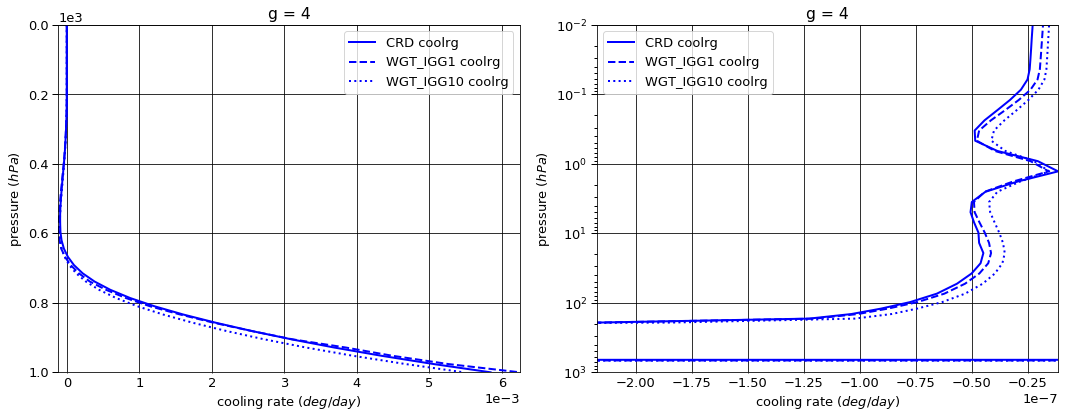

# Figure: cooling rate g-group total

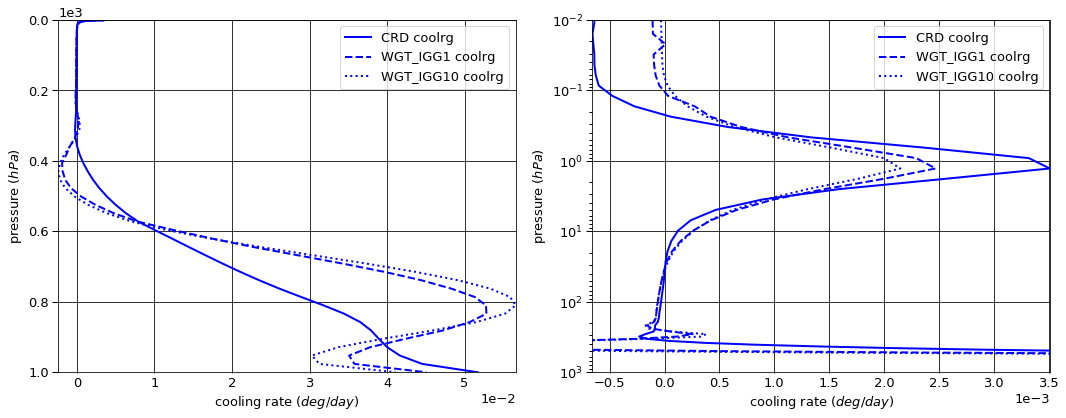

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001837  0.000000 -0.001837
  1013.0   76    -0.014815  0.014777 -0.000038
2 0.0      1     -0.049850  0.000000 -0.049850
  1013.0   76    -0.333407  0.332894 -0.000513
3 0.0      1     -2.562068  0.000000 -2.562068
  1013.0   76    -3.764075  2.639415 -1.124660
4 0.0      1     -2.483385  0.000000 -2.483385
  1013.0   76    -2.513155  0.116414 -2.396741


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001184  0.000000 -0.001184
  1013.0   76    -0.014815  0.014793 -0.000022
2 0.0      1     -0.034913  0.000000 -0.034913
  1013.0   76    -0.333407  0.332927 -0.000480
3 0.0      1     -2.068156  0.000000 -2.068156
  1013.0   76    -3.764075  3.559503 -0.204572
4 0.0      1     -2.482052  0.000000 -2.482052
  1013.0   76    -2.513155  0.118617 -2.394538


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001116  0.000000 -0.001116
  1013.0   76    -0.014815  0.014793 -0.000022
2 0.0      1     -0.034387  0.000000 -0.034387
  1013.0   76    -0.333407  0.332927 -0.000480
3 0.0      1     -2.050470  0.000000 -2.050470
  1013.0   76    -3.764075  3.598130 -0.165945
4 0.0      1     -2.486619  0.000000 -2.486619
  1013.0   76    -2.513155  0.102490 -2.410665


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      6.520941e-04  0.000000  0.000652
  1013.0   76    -1.734723e-18  0.000016  0.000016
2 0.0      1      1.493697e-02  0.000000  0.014937
  1013.0   76     0.000000e+00  0.000033  0.000033
3 0.0      1      4.939126e-01  0.000000  0.493913
  1013.0   76     0.000000e+00  0.920088  0.920088
4 0.0      1      1.333100e-03  0.000000  0.001333
  1013.0   76     0.000000e+00  0.002203  0.002203


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      7.208483e-04  0.000000  0.000721
  1013.0   76    -1.734723e-18  0.000016  0.000016
2 0.0      1      1.546258e-02  0.000000  0.015463
  1013.0   76     0.000000e+00  0.000033  0.000033
3 0.0      1      5.115978e-01  0.000000  0.511598
  1013.0   76     0.000000e+00  0.958715  0.958715
4 0.0      1     -3.233600e-03  0.000000 -0.003234
  1013.0   76     0.000000e+00 -0.013924 -0.013923

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.743446e-04
  1001.112500 75     1.305741e-05
2 0.000312    1     -1.242307e-07
  1001.112500 75     1.838547e-04
3 0.000312    1     -3.384786e-06
  1001.112500 75     4.567318e-02
4 0.000312    1     -2.093021e-08
  1001.112500 75     5.844999e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.228870e-04
  1001.112500 75     7.682368e-06
2 0.000312    1     -7.408382e-08
  1001.112500 75     1.704218e-04
3 0.000312    1     -3.163824e-06
  1001.112500 75     3.864435e-02
4 0.000312    1     -1.596484e-08
  1001.112500 75     6.248877e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -4.611737e-05
  1001.112500 75     7.682368e-06
2 0.000312    1     -7.562462e-08
  1001.112500 75     1.704218e-04
3 0.000312    1     -3.021857e-06
  1001.112500 75     3.544217e-02
4 0.000312    1     -1.356321e-08
  1001.112500 75     5.473620e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.514576e-04
  1001.112500 75    -5.375040e-06
2 0.000312    1      5.014689e-08
  1001.112500 75    -1.343293e-05
3 0.000312    1      2.209620e-07
  1001.112500 75    -7.028829e-03
4 0.000312    1      4.965370e-09
  1001.112500 75     4.038783e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.282272e-04
  1001.112500 75    -5.375040e-06
2 0.000312    1      4.860609e-08
  1001.112500 75    -1.343293e-05
3 0.000312    1      3.629283e-07
  1001.112500 75    -1.023100e-02
4 0.000312    1      7.367001e-09
  1001.112500 75    -3.713789e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.097139,0.0000,-5.097139
1013.0,76,-6.625452,3.1035,-3.521952



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.586305,0.00000,-4.586305
1013.0,76,-6.625452,4.02584,-2.599612



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.572592,0.000000,-4.572592
1013.0,76,-6.625452,4.048341,-2.577112



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.510835,0.00000,0.510835
1013.0,76,0.000000,0.92234,0.922340



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.524548,0.00000,0.524548
1013.0,76,0.000000,0.94484,0.944840


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000678
1001.112500,75,0.051715



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000126
1001.112500,75,0.045071



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000049
1001.112500,75,0.041094



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000552
1001.112500,75,-0.006644



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000629
1001.112500,75,-0.010621


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000982,0.002553
2,0.016755,0.058810
3,0.410545,0.614270
4,0.571718,0.324366


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.033657e-21
2,3.397461e-22
3,5.000002e-25
4,6.466739e-29


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.033657e-21,NaN,0.000982,0.002553,0.000982,0.002553,1.0
2,3.397461e-22,0.167062,0.016755,0.058810,0.017736,0.061364,500.0
3,5.000002e-25,0.001472,0.410545,0.614270,0.428282,0.675634,500.0
4,6.466739e-29,0.000129,0.571718,0.324366,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     1.039277e-19  2.639334e-21   39.376502  4.106395e-06
      2 0.000312     2.287379e-24  1.631848e-24    1.401711  1.696742e-10
      3 0.000312     1.266697e-24  1.247141e-26  101.568090  7.048942e-11
      4 0.000312     3.078408e-27  4.455014e-30  690.998400  2.490717e-13
2     1 0.000750     1.042049e-19  2.647590e-21   39.358390  1.658435e-06
      2 0.000750     2.314071e-24  1.650661e-24    1.401905  6.913647e-11
      3 0.000750     1.271991e-24  1.254241e-26  101.415200  2.851110e-11
      4 0.000750     3.102267e-27  4.520083e-30  686.329710  1.011004e-13
3     1 0.001052     1.047941e-19  2.664588e-21   39.328455  2.338971e-06
      2 0.001052     2.358454e-24  1.678812e-24    1.404835  9.873966e-11
      3 0.001052     1.283290e-24  1.265779e-26  101.383430  4.033878e-11
      4 0.001052     3.153613e-27  4.588289e-30  687.317740  1.441283e-13
4     1 0.001476     1.054192e-19  2.682855e-21   39.293657  3.300983e-06
      2 0.001476     2.408403e-24  1.711031e-24    1.407575  1.413534e-10
      3 0.001476     1.295413e-24  1.278677e-26  101.308870  5.712578e-11
      4 0.001476     3.209133e-27  4.673499e-30  686.666060  2.057562e-13
5     1 0.002070     1.060461e-19  2.701484e-21   39.254747  4.657587e-06
      2 0.002070     2.462813e-24  1.747102e-24    1.409657  2.026295e-10
      3 0.002070     1.307721e-24  1.292677e-26  101.163750  8.088575e-11
      4 0.002070     3.265937e-27  4.780092e-30  683.237100  2.936993e-13
6     1 0.002904     1.066742e-19  2.720543e-21   39.210640  6.572295e-06
      2 0.002904     2.523153e-24  1.788501e-24    1.410764  2.911159e-10
      3 0.002904     1.320210e-24  1.308201e-26  100.917980  1.145466e-10
      4 0.002904     3.324008e-27  4.917039e-30  676.018280  4.193089e-13
7     1 0.004074     1.073036e-19  2.740147e-21   39.159774  9.274197e-06
      2 0.004074     2.591543e-24  1.837148e-24    1.410634  4.194528e-10
      3 0.004074     1.332891e-24  1.325829e-26  100.532660  1.622296e-10
      4 0.004074     3.383387e-27  5.096238e-30  663.899080  5.987036e-13
8     1 0.005714     1.079340e-19  2.760464e-21   39.099970  1.308577e-05
      2 0.005714     2.670965e-24  1.895844e-24    1.408852  6.066707e-10
      3 0.005714     1.345775e-24  1.346381e-26   99.954961  2.297628e-10
      4 0.005714     3.444120e-27  5.334269e-30  645.659130  8.548659e-13
9     1 0.008015     1.085658e-19  2.781727e-21   39.028193  1.846407e-05
      2 0.008015     2.765624e-24  1.968534e-24    1.404915  8.820521e-10
      3 0.008015     1.358881e-24  1.371019e-26   99.114692  3.254453e-10
      4 0.008015     3.506268e-27  5.654242e-30  620.112890  1.220775e-12
10    1 0.011243     1.091985e-19  2.804258e-21   38.940254  2.605219e-05
      2 0.011243     2.881426e-24  2.060702e-24    1.398274  1.291309e-09
      3 0.011243     1.372230e-24  1.401360e-26   97.921279  4.610150e-10
      4 0.011243     3.569884e-27  6.087715e-30  586.407930  1.743452e-12
11    1 0.015771     1.098321e-19  2.828509e-21   38.830400  3.675905e-05
      2 0.015771     3.026689e-24  2.179987e-24    1.388397  1.907653e-09
      3 0.015771     1.385848e-24  1.439662e-26   96.262077  6.531529e-10
      4 0.015771     3.635032e-27  6.677239e-30  544.391430  2.490216e-12
12    1 0.022122     1.104667e-19  2.855117e-21   38.690760  5.186584e-05
      2 0.022122     3.213165e-24  2.336981e-24    1.374922  2.851069e-09
      3 0.022122     1.399782e-24  1.489064e-26   94.004182  9.255187e-10
      4 0.022122     3.701828e-27  7.479214e-30  494.948850  3.557270e-12
13    1 0.031031     1.111023e-19  2.884969e-21   38.510746  7.318200e-05
      2 0.031031     3.457423e-24  2.546236e-24    1.357856  4.323421e-09
      3 0.031031     1.414096e-24  1.553906e-26   91.002669  1.311759e-09
      4 0.031031     3.770434e-27  8.566566e-30  440.133690  5.082373e-12
14    1 0.043528     1.117802e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
